**Get Data and Visualize**

In [1]:
import pandas as pd

df = pd.read_csv('Data_Households_SmartPV.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

weekday_df = df[df['Timestamp'].dt.dayofweek < 5]
weekday_avg = weekday_df.groupby([weekday_df['Timestamp'].dt.hour, weekday_df['Timestamp'].dt.minute]).mean()
timestamps = pd.date_range(start='2016-06-15 00:00:00', end='2016-06-15 23:30:00', freq='30min')
weekday_avg['Timestamp'] = timestamps
weekday_avg.set_index('Timestamp', inplace=True)
weekday_avg = weekday_avg / 1000  # Convert to kWh
weekday_avg.head()




,NM_meter,Import,Export,PV_meter,Production,Consumption,NetLoad
Timestamp,,,,,,,
2016-06-15 00:00:00,0.614941,0.845336,0.0,0.586632,0.0,0.845336,0.845336
2016-06-15 00:30:00,0.614931,0.789306,0.0,0.586633,0.0,0.789306,0.789306
2016-06-15 01:00:00,0.614941,0.747229,0.0,0.586632,0.0,0.747229,0.747229
2016-06-15 01:30:00,0.614931,0.720732,0.0,0.586633,0.0,0.720732,0.720732
2016-06-15 02:00:00,0.614941,0.688052,0.0,0.586632,0.0,0.688052,0.688052


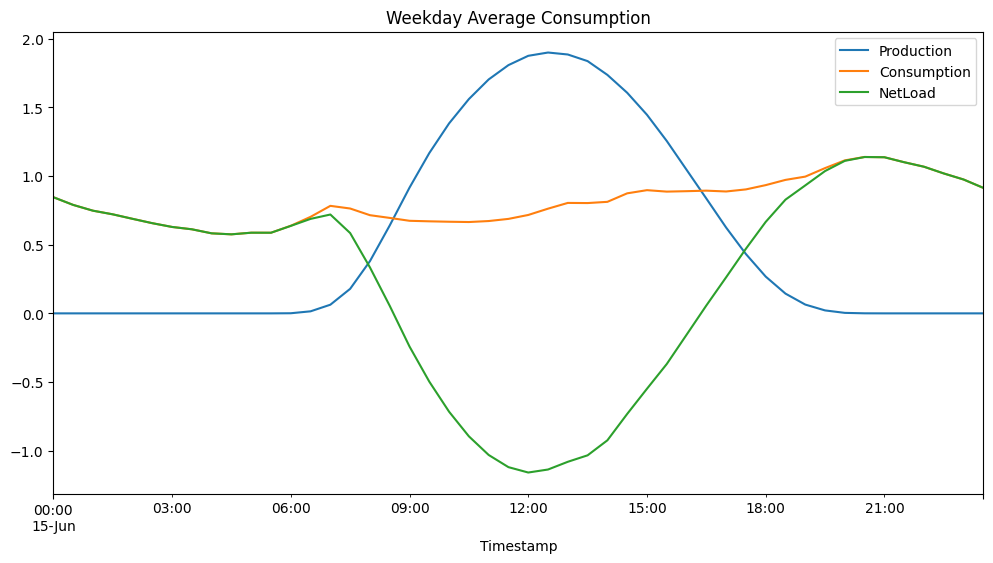

In [2]:
import matplotlib.pyplot as plt
_ = weekday_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Weekday Average Consumption', figsize=(12, 6))

**Battery Control**

This optimization is the basic scenario of controlling the battery for a day. Primarily, this is meant to test functionality of the optimization before scaling to more complicated pricing schemes. 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 19.305181573546616
            Iterations: 113
            Function evaluations: 5788
            Gradient evaluations: 113


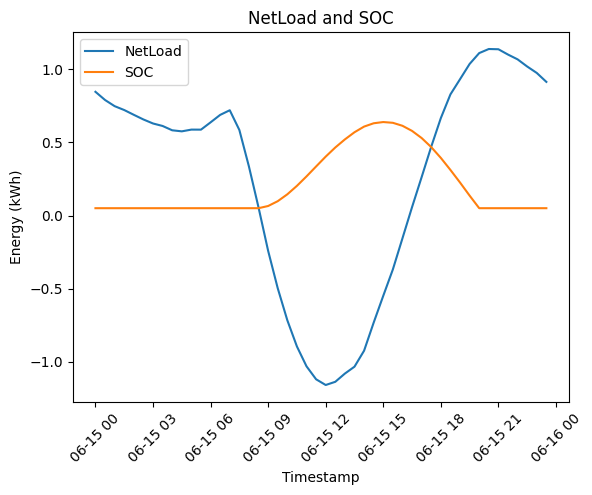

In [3]:
from charge_optimizer import ChargeOptimizer

BATT_PRICE_PER_KWH = 127  # Euros per kWh (127 is what was found online)
max_charge_rate = 0.5  # Max charge rate in % per hour
max_discharge_rate = 0.5  # Max discharge rate in % per hour
soc_min = 0.05  # Maximum Depth of Discharge 95%
soc_max = 1.00  # Maximum State of Charge 100%; can play around with to protect battery
sqrt_eff = 0.98  # round trip Efficiency of the battery
self_discharge = 0.05  # 5% self discharge per day; totally made up
batt_life = 10 # years; totally made up

charge_optimizer = ChargeOptimizer(
    pred_net_load=weekday_avg['NetLoad'],
    duration=1,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5, # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
    batt_capacity=13.5,  # 13.5 kWh
)

charge_optimizer.local_optimize()
soc = charge_optimizer.calc_soc(charge_optimizer.result.x)

plt.plot(weekday_avg.index, weekday_avg['NetLoad'], label='NetLoad')
plt.plot(weekday_avg.index, soc[1:], label='SOC')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.title('NetLoad and SOC')
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Optimization of Battery Size for Net Savings**

This optimization accounts for the price of batteries and finds the optimal battery size to save consumers money (for the specified sample of 3kW systems). This exists for both TOU tariffs and single-price tariffs. 

Information: https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/
https://natec.com/wp-content/uploads/2020/12/6020-0205-Datasheet-LG-Chem-RESU-10H-High-Voltage-400V-type-C-for-SMA.pdf

**Single Price Tariff Optimization**

Although Cyprus uses Net-Metering, this study examines export energy that does not recieve remuneration

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.2591167662152865
            Iterations: 110
            Function evaluations: 5704
            Gradient evaluations: 110
Battery Size: 8.493191388895626 kWh


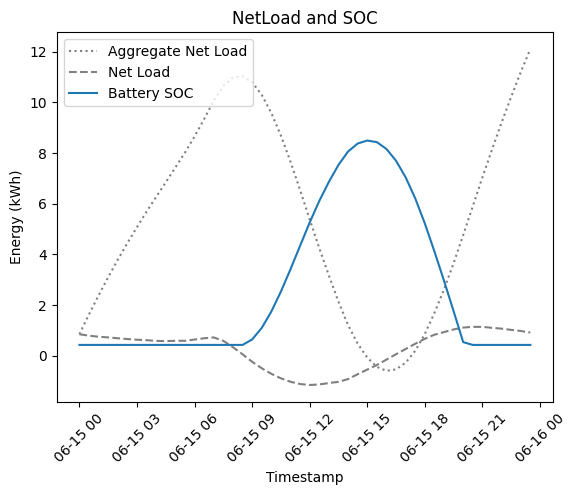

In [26]:
from price_optimizer import PriceOptimizer
import numpy as np

import_tariff = np.full(48, 0.37)
price_optimizer = PriceOptimizer(
    pred_net_load=weekday_avg["NetLoad"],
    duration=1,
    batt_price_per_kWh=BATT_PRICE_PER_KWH,
    import_tariff=import_tariff,
    batt_life=batt_life,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5,  # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
)

price_optimizer.local_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
soc = price_optimizer.calc_soc(price_optimizer.result.x[:-1]) * price_optimizer.result.x[-1]

aggregate = [0]
for num in weekday_avg['NetLoad']:
    aggregate.append(aggregate[-1] + num)

plt.plot(weekday_avg.index, aggregate[1:], label='Aggregate Net Load', linestyle='dotted', color='grey')
plt.plot(weekday_avg.index, weekday_avg['NetLoad'], label='Net Load', color='grey', linestyle='dashed')
plt.plot(weekday_avg.index, soc[1:], label='Battery SOC')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.title('NetLoad and SOC')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [6]:
net_load = weekday_avg['NetLoad'].values
result = local_optimize(net_load, 1)
result.x

NameError: name 'local_optimize' is not defined

9999.996280626307


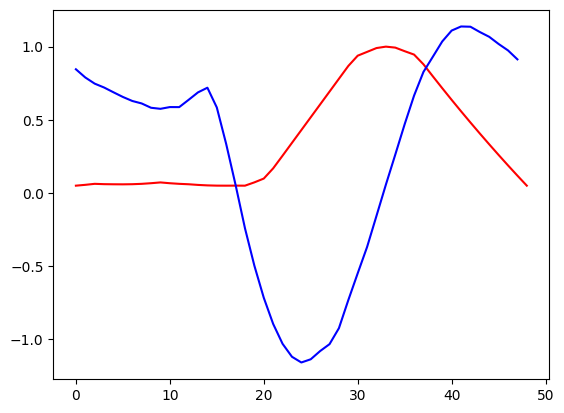

In [ ]:
from turtle import color


print(result.x[-1])
plt.plot(calc_soc(result.x, len(result.x) - 1), color='red')
plt.plot(net_load / 1000, color='blue')

In [ ]:
# Compare costs: 
price_func = get_objective(net_load, 1)
print(price_func(np.zeros(result.x.shape[0] + 1)))
print(price_func(result.x))

4392.133709896003
2689.9116181321688
